# Analyze Corona cases in Switzerland with PySpark

## Download the data from the official Swiss government site as Excel sheet

In [1]:
%%bash
rm -f data.xlsx data.csv
URL='https://www.bag.admin.ch/dam/bag/de/dokumente/mt/k-und-i/aktuelle-ausbrueche-pandemien/2019-nCoV/covid-19-basisdaten-fallzahlen.xlsx.download.xlsx/Dashboards_1&2_COVID19_swiss_data_pv.xlsx'
curl -o data.xlsx -Os $URL
# Apparently, libreoffice is the most performant converter for xlsx to csv
libreoffice --headless --convert-to csv data.xlsx > /dev/null
du -sh data.csv

25M	data.csv


## Initialize a Spark session and load the csv

In [2]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pyspark.sql.types as T
import warnings
import ipywidgets as widgets

In [3]:
spark = SparkSession.builder \
                    .master("local") \
                    .appName("Corona") \
                    .getOrCreate()

df = spark.read.format('csv')\
          .options(header='true')\
          .load('data.csv')

## Clean the dataset and cast to the correct data types

In [4]:
def to_timestamp(name):
    return F.unix_timestamp(F.col(name), 'yyyy-MM-dd').cast('timestamp').cast('date')
    
df_cleaned = df.withColumn('DateCases', to_timestamp('fall_dt'))\
               .withColumn('DateDeaths', to_timestamp('pttoddat'))\
               .withColumn('Date', F.coalesce(F.col('DateCases'), F.col('DateDeaths')))\
               .withColumnRenamed('ktn', 'Canton')\
               .withColumnRenamed('fallklasse_3', 'Cases')\
               .withColumnRenamed('pttod_1', 'Deaths')\
               .drop('sex', 'replikation_dt', 'Sexe', 'Geschlecht', 'akl', 'pttoddat', 'fall_dt', 'DateCases', 'DateDeaths')

In [5]:
df_cleaned.show()

+------+-----+------+----------+
|Canton|Cases|Deaths|      Date|
+------+-----+------+----------+
|    TI|    1|     0|2020-02-24|
|    AG|    1|     0|2020-02-25|
|    BL|    1|     0|2020-02-26|
|    BS|    1|     0|2020-02-26|
|    GE|    1|     0|2020-02-26|
|    GR|    2|     0|2020-02-26|
|    GR|    1|     0|2020-02-26|
|    GR|    1|     0|2020-02-26|
|    JU|    1|     0|2020-02-26|
|    VD|    1|     0|2020-02-26|
|    ZH|    1|     0|2020-02-26|
|    BE|    1|     0|2020-02-27|
|    BE|    1|     0|2020-02-27|
|    GE|    1|     0|2020-02-27|
|    GE|    1|     0|2020-02-27|
|    GE|    1|     0|2020-02-27|
|    GR|    1|     0|2020-02-27|
|    GR|    1|     0|2020-02-27|
|    TI|    1|     0|2020-02-27|
|    TI|    2|     0|2020-02-27|
+------+-----+------+----------+
only showing top 20 rows



## Group the data by canton

In [6]:
cantons = sorted([str(x.Canton) for x in df_cleaned.select(F.col('Canton')).distinct().collect()])
canton = None
@widgets.interact(Canton=widgets.Dropdown(options = ['All'] + cantons))
def select_canton(Canton):
    global canton
    canton = Canton
    print(f'Selected canton {canton}')

interactive(children=(Dropdown(description='Canton', options=('All', 'AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FL',…

In [7]:
if canton and canton != 'All':
    df_select = df_cleaned.filter(F.col('Canton') == canton)
else:
    df_select = df_cleaned

In [8]:
df_grouped = df_select.groupby('Date')\
                      .agg(F.sum(F.col('Cases')).alias('Cases'), F.sum(F.col('Deaths')).alias('Deaths'))\
                      .sort(F.col('Date'))\
                      .filter(F.col('Date').isNotNull())

## Calculate the moving average for the cases and deaths

In [9]:
days_window=7
@widgets.interact(Days=(1, 14))
def select_days(Days):
    global days_window
    days_window = Days
    print(f'Selected window of {days_window} days')

interactive(children=(IntSlider(value=7, description='Days', max=14, min=1), Output()), _dom_classes=('widget-…

In [10]:
window = Window.orderBy(F.col("Date").cast("timestamp").cast("long")) \
               .rangeBetween(-86400 * (days_window - 1), 0)
for name in ['Deaths', 'Cases']:
    df_grouped = df_grouped.withColumn(name + 'Avg', F.mean(F.col(name)).over(window))

In [11]:
df_grouped.show()

+----------+-----+------+-------------------+------------------+
|      Date|Cases|Deaths|          DeathsAvg|          CasesAvg|
+----------+-----+------+-------------------+------------------+
|2020-02-24|  1.0|   0.0|                0.0|               1.0|
|2020-02-25|  1.0|   0.0|                0.0|               1.0|
|2020-02-26| 10.0|   0.0|                0.0|               4.0|
|2020-02-27| 11.0|   0.0|                0.0|              5.75|
|2020-02-28| 10.0|   0.0|                0.0|               6.6|
|2020-02-29| 13.0|   0.0|                0.0| 7.666666666666667|
|2020-03-01| 11.0|   0.0|                0.0| 8.142857142857142|
|2020-03-02| 31.0|   0.0|                0.0|12.428571428571429|
|2020-03-03| 33.0|   0.0|                0.0|              17.0|
|2020-03-04| 61.0|   0.0|                0.0|24.285714285714285|
|2020-03-05| 62.0|   2.0| 0.2857142857142857|31.571428571428573|
|2020-03-06| 73.0|   0.0| 0.2857142857142857| 40.57142857142857|
|2020-03-07| 49.0|   0.0|

## Plot the time series

In [12]:
pdf = df_grouped.toPandas()

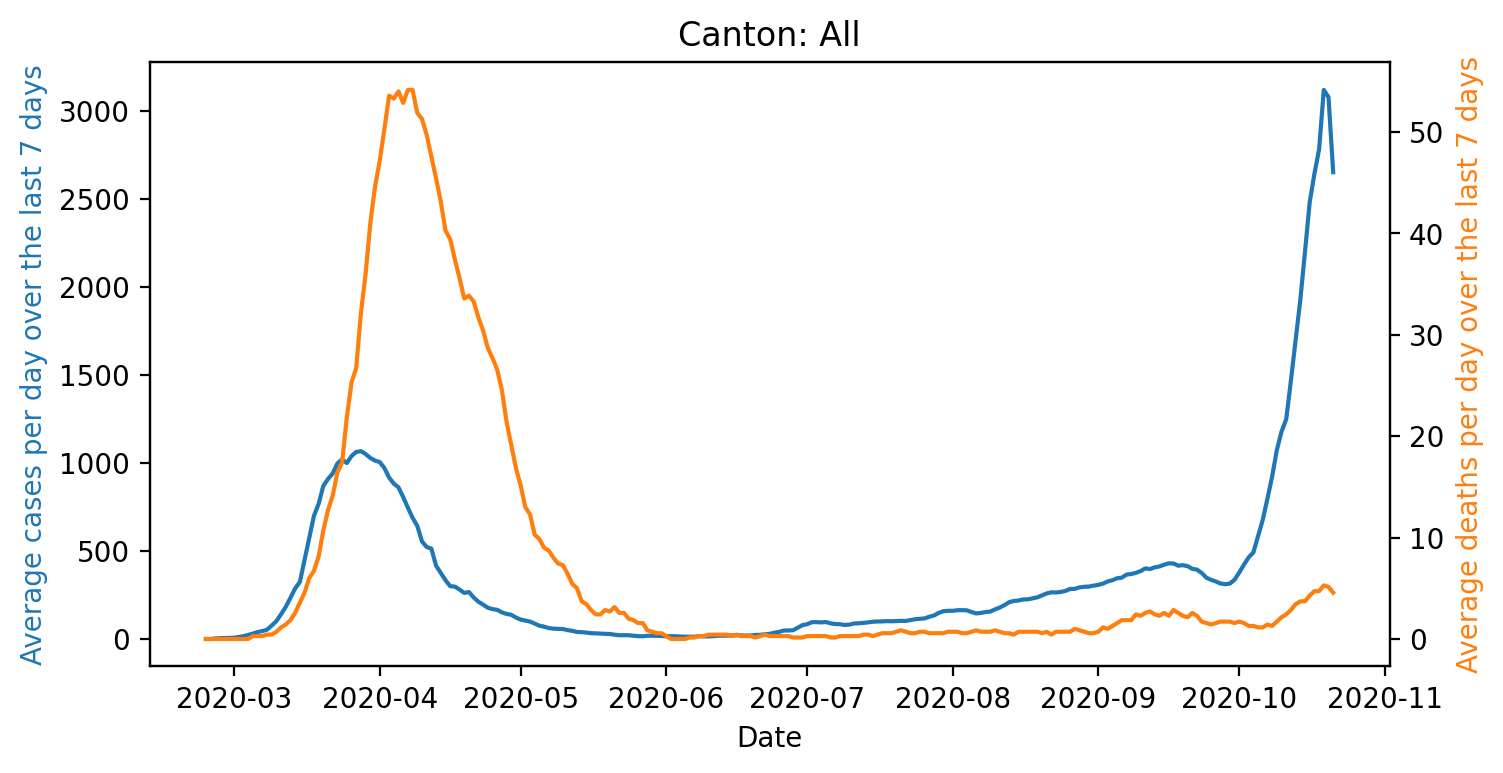

In [13]:
warnings.filterwarnings("ignore", category=FutureWarning)
plt.figure(figsize=(8, 4), dpi=200)
ax1 = plt.gca()
ax1.plot(pdf['Date'], pdf['CasesAvg'], color='C0')
ax2 = ax1.twinx()
ax2.plot(pdf['Date'], pdf['DeathsAvg'], color='C1')
ax1.set_xlabel('Date')
ax1.set_ylabel(f'Average cases per day over the last {days_window} days', color='C0')
ax2.set_ylabel(f'Average deaths per day over the last {days_window} days', color='C1')
plt.title(f'Canton: {canton}')
plt.savefig('plot.png')